<a href="https://colab.research.google.com/github/garestrear/introduccion_ML_cursoUN/blob/main/Sesion12-Series_de_tiempo_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de series de tiempo
En esta segunda sesión sobre series de tiempo veremos algunas de las técnicas existentes para analizar series de tiempo univariadas. Entre los conceptos que estudiaremos se encuentran: 
- Series de tiempo estacionaria
- Funciones de autocorrelación y autocorrelación parcial 
- Modelos $AR(p)$, $MA(q)$ y $ARMA(p,q)$
- Una generalización de los modelos anteriores llamados $ARIMA(p,d,q)$
- Modelos $SARIMAX(p,d,q)(P,D,Q)_S$ que tienen en cuenta componentes estacionales.

Ademas de estudiar los conceptos e implementar algunos modelos de series de tiempo, veremos modelos de diagnóstico para el ajuste y calibración de los mismos.

## Series de tiempo estacionarias 

Este primer concepto de estacionariedad es clave. La razón es que los modelos que estudiaremos (y casi todos los modelos aplicados) asumen que la serie de tiempo es estacionaria. Podemos pensar que una serie estacionaria satisface 
- La media de la serie es constante (no sigue una tendencia)
- La varianza de la serie es constante.
- La covarianza entre dos periodos depende solo de la distancia entre estos periodos.
Veamos algunos gráficas para indentificar series estacionarias

<p float="center">
  <img src='https://raw.githubusercontent.com/wincy-guerra/Times-Series-Data/main/3lKCxEn.png' width="500" />
</p>

Estaremos trabajando, entre otros, con la cotización de la libra de café en la bolsa de Nueva York.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use('ggplot')

In [ ]:
from IPython.core.pylabtools import figsize
figsize(12, 8)

In [ ]:
caf = 'https://raw.githubusercontent.com/wincy-guerra/Times-Series-Data/main/Datos%20hist%C3%B3ricos%20Futuros%20caf%C3%A9%20C%20EE.UU.%20(1).csv'
cafe = pd.read_csv(caf)
cafe.head(10)

In [ ]:
cafe.info()

In [ ]:
cafe['Fecha'] = pd.to_datetime(cafe['Fecha'],format= '%d.%m.%Y')
cafe.info()

In [ ]:
cafe.set_index('Fecha',inplace=True)
cafe.head()

Note que las fechas están en orden descendente

In [ ]:
cafe = cafe.sort_index(ascending=True)
cafe.head()

Transformaremos la columna `Último` a tipo numérico.

In [ ]:
cafe['Último']=cafe['Último'].apply(lambda x: x.replace(',','.'))
cafe['Último']=pd.to_numeric(cafe['Último'])
cafe.info()

In [ ]:
cafe['Último'].plot()
plt.title('Precios del café (por libras en centavos de dólar)')
plt.show()

Importemos ahora datos sobre el clima

In [ ]:
cli = 'https://raw.githubusercontent.com/wincy-guerra/Times-Series-Data/main/Datos%20climaticos_1.csv'
#Note los argumentos "encoding"  y "sep" en la función
clima = pd.read_csv(cli,encoding='latin',sep=';')
clima.columns = ['FECHA', 'AÑO', 'MES', 'DÍA', 'hora', 'Solar Rad (wat/m2)',
       'Temperatura', 'RH (%)', 'Wind Dir (Deg)', 'Wind Gust (km/h)',
       'Wind Speed (km/h)', 'Rainfall (mm)']
clima['FECHA'] = pd.to_datetime(clima['FECHA'],format= '%d/%m/%Y')
clima.hora = clima.hora + ':00'
clima.hora = pd.to_timedelta(clima.hora)
clima['date'] = clima['FECHA'] + clima['hora']
clima.set_index('date',inplace=True)
clima = clima[['Temperatura','Rainfall (mm)']]
clima['Temperatura']=clima['Temperatura'].apply(lambda x: str(x))
clima['Temperatura']=clima['Temperatura'].apply(lambda x: x.replace(',','.'))
clima['Rainfall (mm)']=clima['Rainfall (mm)'].apply(lambda x: str(x))
clima['Rainfall (mm)']=clima['Rainfall (mm)'].apply(lambda x: x.replace(',','.'))
clima['Temperatura'] = pd.to_numeric(clima['Temperatura'],errors='coerce')
clima['Rainfall (mm)'] = pd.to_numeric(clima['Rainfall (mm)'],errors='coerce')
clima.sample(10)

In [ ]:
clima.plot(subplots=True)
plt.show()

Ahora quitaremos los valores extremos reemplazando por el valor promedio de un día de ese mismo mes.

In [ ]:
clima[clima['Temperatura']<0] = clima.loc['2016-6-12']['Temperatura'].mean()
clima['Temperatura'].plot()
plt.show()

In [ ]:
clima['2017':]['Temperatura'].resample('D').mean().plot()
plt.show()

¿cómo ubicar los `NaN` dentro del DataFrame?

In [ ]:
clima[clima['Temperatura'].isna()]


En esta sesión usaremos la librería `statsmodels` para el análisis de series de tiempo y la formulación de modelos.

In [ ]:
import statsmodels.api as sm 


Recordemos que un modelo usual para el precio de un activo es una caminata aleatoria 

$$ p_t = p_{t-1} + \epsilon _t $$

Un test estadistico para determinar si una serie de tiempo sigue una caminata aleatoria es el **test de Dickey-Fuller aumentado**. Indirectamente este test nos permite evaluar si una serie de tiempo es estacionaria siempre que la estacionariedad se pierda debido a que la serie tiene una tendencia. El lector interesado puede revisar más sobre el test de Dickey-Fuller pinchando [acá](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test)

- `adfuller`

In [ ]:
## Importamos la herramienta para aplicar el test
from statsmodels.tsa.stattools import adfuller

Aplicaremos el test anterior a los datos del precio del café y la serie climática.

In [ ]:
test_0 = adfuller(cafe['2010':]['Último'])
##Resultados test
print(test_0)
##Imprimimos el p valor
print(test_0[1])

Los resultados anteriores nos muestran que no podemos rechazar la hipótesis de que la serie de precios del café sigue una caminata aleatoria. Desde un punto de vista pragmático este resultado nos señala que la serie **no es estacionaria**. Recordemos que si el **p valor** es menor a 0.05 (menor al 5%) podemos rechazar la hipótesis o, podemos asumir que la serie es estacionaria.

In [ ]:
test_1 = adfuller(clima['2017':]['Temperatura'].resample('D').mean().dropna()) 
test_1[1]  

Note que el **p valor** del test es menor a 0.05 (de hecho muy pequeño), por tanto la temperatura durante el 2017 no sigue una caminata aleatoria. Podemos asumir que la serie es estacionaria. 

La mayor parte de series de tiempo que encontraremos no son estacionarias (como el precio diario del café), sin embargo, algunas transformaciones matemáticas en los datos pueden hacerlas estacionarias. Algunas de las operaciones mas usuales son:
- Tomar logaritmo natural.
- Tomar la diferencia en intervalos fijos de tiempo para la serie dada.
- Tomar la diferencia entre los logaritmos (usual en econometría).

En la siguiente línea analizaremos el precio mensual del café del 2010 en adelante.

In [ ]:
cafe_m = cafe['2010':]['Último'].resample('M').last()
cafe_m = pd.DataFrame(cafe_m)
cafe_m['Retornos'] = cafe_m['Último'].diff()
cafe_m.head()

In [ ]:
cafe_m.plot(subplots=True)
plt.title('Retornos mensuales del precio del café')
plt.show()

veamos qué nos dice el test de Dickey-Fuller sobre la serie de retornos mensuales del café.

In [ ]:
test = adfuller(cafe_m['Retornos'].dropna())
test[1]

## Funciones de autocorrelación y autocorrelación parcial 

**La autocorrelación** en una serie de tiempo estacionaria es la correlación de la serie  con un "retraso" de ella misma. Es decir 
$$\gamma_{X}(\tau) = \rho(X_{t+\tau},X_t)$$

Si existe autocorrelación en una serie de tiempo se tienen los siguientes dos fenómenos 

- Autocorrelación negativa: En este caso de dice que la serie tiene regresión a la media
<p float="center">
  <img src='https://raw.githubusercontent.com/wincy-guerra/Times-Series-Data/main/autocorr-neg.jpg' width="600" />
</p>

- Autocorrelación positiva: En este caso se dice que la serie sigue la tendencia (momento)

<p float='center'>
  <img src = 'https://raw.githubusercontent.com/wincy-guerra/Times-Series-Data/main/autocorr-pos.png' width='600' />
<\p>

En cualquier caso una autocorrelación significativamente diferente de cero en una serie de tiempo estacionaria indica que tenemos posibilidades de implementar  buenos modelos matemáticos. 

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Para ver los valores (no las gráficas) del las funciones de autocorrelación y autocorrelación parcial podemos usar
- `from statsmodels.tsa.stattools import acf`
- `from statsmodels.tsa.stattools import pacf`

In [ ]:
plot_acf(clima['2016':]['Temperatura'].resample('W').min().dropna(),lags=30,zero=False)
plt.show()

In [ ]:
clima_sem = clima['2016':]['Temperatura'].resample('W').min()
clima_sem.plot()
plt.show()

In [ ]:
clima_sem = pd.DataFrame(clima_sem)
clima_sem.columns = ['Temperatura']
clima_sem.head()

In [ ]:
test = adfuller(clima_sem['Temperatura'].dropna())
test[1]

Los datos de temperaturas mínimas semanales pasan el test de Dickey-Fuller, por tanto podemos considerar que son estacionarios.

Acontinuación graficaremos la función de autocorrelación para la serie de datos climáticos semanales.

In [ ]:
plot_acf(clima_sem['Temperatura'],alpha=0.05,lags=60)
plt.show()

En este caso tenemos una autocorrelación significativa hasta el segundo retraso. **Los valores dentro del área sombreada no se consideran estadísticamente significativos**.

**La función de autocorrelación parcial hasta el retraso k** determina la autocorrelación en la serie en ese retraso eliminando los efectos causados por los retrasos anteriores a k. 

In [ ]:
clima_sem.shape

In [ ]:
plot_pacf(clima_sem['Temperatura'],lags=15,zero=False)
plt.show()

Veamos la función de autocorrelación y autocorrelación parcial para el retorno mensual del precio del café

In [ ]:
fig, ax = plt.subplots(1,2)
plot_acf(cafe_m['Retornos'].dropna(),lags=20,zero=False,ax=ax[0])
plot_pacf(cafe_m['Retornos'].dropna(),lags=20,zero=False,ax=ax[1])
plt.show()

In [ ]:
plot_acf(cafe_m['Último'].dropna())
plt.show()

##Modelos ARMA
Estudiaremos ahora uno de los modelos más populares para hacer pronósticos usando series de tiempo: modelos ARMA. Para entender algunos conceptos y familiarizarnos con este tipo de modelos usaremos herramientas de la librería `statsmodels` con el fin de simular estos procesos.

### Modelos autoregresivos

En un modelo autoregresivo, el valor actual de la serie de tiempo depende de una media mas una fracción del valor anterior, mas un ruido.

$$ x_t = \mu + \alpha x_{t-1} + \epsilon_t.$$
De hecho, si consideramos solo un valor anterior decimos que es un modelo $AR$ de orden 1, AR(1). En general podemos considerar modelos $AR$ de orden n como 
$$x_t = \mu + \alpha_1 x_{t-1}+\alpha_2x_{t-2}+\cdots +\alpha_n x_{t-n}+\epsilon_t $$
en cuyo caso denotamos AR(n). Los coeficientes $\alpha$ deben estar entre -1 y 1 para que el proceso sea estacionario.
- si $\alpha$ es negativo en un AR(1) tenemos reversión a la media.
- si $\alpha$ es positivo sigue la tendencia (momentum).
Solo para ilustrar algunos conceptos usaremos datos simulados. `statsmodel` incluye una herramienta para simular esta clase de procesos. 

In [ ]:
from statsmodels.tsa.arima_process import ArmaProcess

Simularemos datos para dos modelos AR(1).
1. $$x_t=0.9 x_{t-1}+\epsilon_t$$
2. $$x_t=-0.9 x_{t-1}+\epsilon_t$$
**Note el signo trocado en los comandos**

In [ ]:
# Modelo 1: Parámetro AR = 0.9
ar1 = np.array([1, -0.9])
ma1 = np.array([1])
AR_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = AR_object1.generate_sample(nsample=1000)

# Modelo 2: Parámetro AR = -0.9
ar2 = np.array([1, 0.9])
ma2 = np.array([1])
AR_object2 = ArmaProcess(ar2, ma2)
simulated_data_2 = AR_object2.generate_sample(nsample=1000)

Veamos las trayectorias generadas por estos procesos simulados 

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(12,5), sharey=True, sharex=True)
# Primera gráfica
axs[0].plot(simulated_data_1)
# Segunda gráfica
axs[1].plot(simulated_data_2)

# Etiquetas de los ejes 
axs[0].set_title('alpha=0.9', c= 'red', fontsize = 16)#fontsize cambia el tamaño de la letra

# Nombre de los ejes y título 
axs[1].set_title('alpha=-0.9', c= 'red', fontsize = 16)#fontsize cambia el tamaño de la letra

# Título de toda la figura
fig.suptitle('Simulación de dos procesos AR(1)', fontsize = 20, color = 'black') 

plt.show()

Graficaremos ahora las funciones de autocorrelación y autocorrelación parcial para cada uno de los datos simulados. **Es importante notar las formas de estas funciones, el decaimento exponencial en la primera y como la segunda solo tiene un valor estadísticamente significativo**.

In [ ]:
## Graficamos las funciones de autocorrelación y autocorrelación parcial
## para los datos de los dos procesos simulados.
fig, ax = plt.subplots(2,2,sharex=True)
## Gráfica para alpha=0.9
plot_acf(simulated_data_1, zero=False, alpha=0.05, lags=20,ax=ax[0,0])
plot_pacf(simulated_data_1, zero=False,  alpha=0.05, lags=20,ax=ax[0,1])
## gráfica para alpha=-0.9
plot_acf(simulated_data_2,zero=False, alpha=0.05, lags=20,ax=ax[1,0])
plot_pacf(simulated_data_2, zero=False, alpha=0.05, lags=20,ax=ax[1,1])
plt.show()

Veremos ahora como ajustar un modelo $AR$ a nuestros datos. En principio ajustaremos los datos simulados como un ejercicio pedagógico. En este caso importaremos la clase `ARMA` de `statsmodels.tsa.arima_models`.

In [ ]:
from statsmodels.tsa.arima_model import ARMA

In [ ]:
## Creamos el modelo
mod = ARMA(simulated_data_1, order=(1,0))
## Entrenamos el modelo con los datos 
res = mod.fit()

# visualizamos la información del ajuste 
print(res.summary())

# imprimimos el estimados para la constante alpha
print("cuando  alpha=0.9 (constante=0), el estimado para alpha (y la constante) son:")
print(res.params)

Usando es objeto `res` que fue entrenado para el modelo usando la data, podemos hacer pronósticos para el modelo $AR$. Recordemos que en este caso tenemos una data simulada con 1000 valores.
- `.plot_predict()`
- `.predict()`

In [ ]:
res.plot_predict(start=900, end=1030)
plt.show()

Como un ejercicio ajustaremos un modelo $AR(2)$ a las temperaturas mínimas contenidas en el DataFrame `clima_sem`.

In [ ]:
modelo = ARMA(clima_sem.dropna(), order=(2,0))
##Entrenamos el modelo 
resultado = modelo.fit()

In [ ]:
clima_sem['Temperatura'].tail()

Ahora que ajustamos nuestro modelo podemos hacer pronósticos sobre la remperatura.

In [ ]:
resultado.plot_predict(start='2017',end='2018-06')
plt.legend(fontsize=12)
#clima['2018-02':]['Temperatura'].resample('W').min().plot(color='g',label='Temperatura real')
plt.show()

Como vemos anteriormente el modelo ajustado no nos da muy buenos resultados. Una pregunta natural es: **¿Cómo escoger un buen modelo para nuestros datos?**. En general esta es una pregunta difícil. Si nos restringimos a los modelos autoregresivos (o ARMA, mas generalmente) algunas  herramientas útiles son 
- la función de autocorrelación parcial.
- Criterios estándar de selección ( Akaike information criteria (AIC) y Bayesian information criteria (BIC))

Notemos que `.summary()` nos da el valor de los criterios AIC y BIC. 

In [ ]:
resultado.summary()

In [ ]:
print(resultado.aic)
print(resultado.bic)

Un menor AIC o BIC nos dirá que tenemos un mejor modelo para nuestros datos. No siempre los modelos coinciden usando estos dos índices. 

Ahora para ver cómo las funciones de autocorrelación y autocorrelación parcial pueden ser útiles para determinar el orden de un modelo $AR(p)$ simularemos de nuevo dos procesos $AR$: un modelo  $AR(1)$ y un modelo $AR(2)$.

In [ ]:
# Simulación AR(1) con alpha=+0.6
ma = np.array([1])
ar = np.array([1, -0.6])
AR_object = ArmaProcess(ar, ma)
simulated_data_3 = AR_object.generate_sample(nsample=5000)

# Plot PACF for AR(1)
#plot_pacf(simulated_data_3, zero=False, lags=20)
#plt.show()

# Simulación AR(2) with alpha1=+0.6, alpha2=+0.3
ma = np.array([1])
ar = np.array([1, -0.6, -0.3,0.3])
AR_object = ArmaProcess(ar, ma)
simulated_data_4 = AR_object.generate_sample(nsample=5000)

# Plot PACF for AR(2)
#plot_pacf(simulated_data_4, zero=False, lags=20)
#plt.show()

Graficaremos ahora las funciones de autocorrelación y autocorrelación parcial para estos datos simulados. **Note el patrón que se presenta en estos dos casos**.

In [ ]:
fig, ax = plt.subplots(2,2,sharex=True)
plot_acf(simulated_data_3, zero=False, alpha=0.05, lags=20,ax=ax[0,0])
plot_pacf(simulated_data_3, zero=False,  alpha=0.05, lags=20,ax=ax[0,1])
plot_acf(simulated_data_4,zero=False, alpha=0.05, lags=20,ax=ax[1,0])
plot_pacf(simulated_data_4, zero=False, alpha=0.05, lags=20,ax=ax[1,1])
plt.show()

Así las cosas, supongamos que nuestros datos satisfacen 
- La función de autocorrelación decae en cada retraso,
- La función de autocorrelación parcial de desvanece después de de un retraso $k$,

entonces la data se puede simular por un procesos $AR(k)$.

Veamos ahora cómo se comporta, por ejemplo, el criterio BIC para la elección de un modelo $AR(p)$. Para esto ajustaremos los datos simulados `simulated_data_4` (que es $AR(2)$) a varios modelos y veremos los valores de este índice.

In [ ]:
## Creamos una lista para almacenas los valores de BIC
BIC = np.zeros(7)
for p in range(7):
    ## Ajustamos datos a distintos ordenes de modelo AR
    mod = ARMA(simulated_data_4, order=(p,0))
    res = mod.fit()
# Guardamos BIC para AR(p)    
    BIC[p] = res.bic
    
# Graficamos BIC como función de p
plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Orden del modelo AR')
plt.ylabel('Bayesian Information Criterion')
plt.show()

In [ ]:
print(BIC)


Hagamos un ejercicio similar para ver cuál podría ser el mejor modelo $AR$ para los datos climáticos de temperaturas mínimas semanales `clima_sem`

In [ ]:
AIC = np.zeros(7)
for p in range(7):
    mod = ARMA(clima_sem.dropna(), order=(p,0))
    res = mod.fit()
# Save BIC for AR(p)    
    AIC[p] = res.aic
    
# gráfica de AIC como función de p
plt.plot(range(1,7), AIC[1:7], marker='o')
plt.xlabel('Orden del modelo AR')
plt.ylabel('Akeike information criteria')
plt.show()

En este caso el criterio AIC sugiere un modelo $AR(2)$, que en efecto fue al que ajustamos.

### modelos de media móvil
En los modelos de media móvil de orden 1 el valor actual de la serie depende de una media, mas un ruido, mas una fracción del ruido del valor anterior
$$ x_t = \mu + \epsilon_t + \theta \epsilon _{t-1}.$$
En este caso denotamos el modelo como $MA(1)$. Si se tienen en cuenta múltiplos de los ruidos n pasos atrás se llama modelo de media móvil de orden n y se denota $MA(n)$
$$ x_t = \mu + \epsilon_t + \theta _1\epsilon_{t-1}+\cdots + \theta_n\epsilon_{t-n} $$

En la siguientes líneas simularemos modelos $MA$ para familiarizarnos con algunos conceptos básicos. La sintaxis para la simulación es idéntica al de modelos $AR$, solo cambia el orden. 


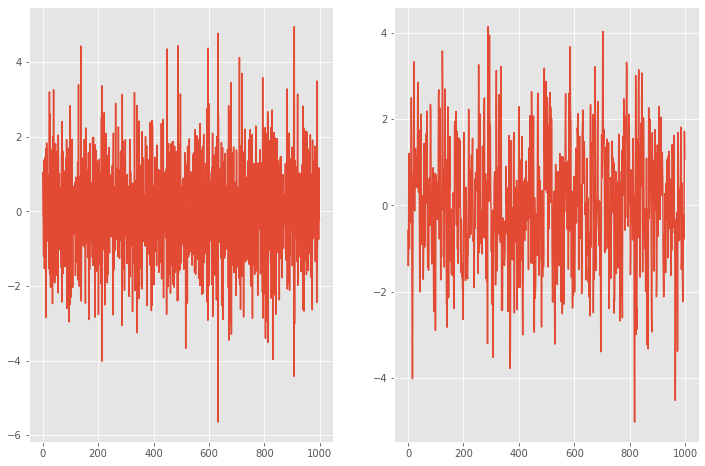

In [ ]:
# Plot 1: Parámetro MA  = -0.9
plt.subplot(1,2,1)
ar1 = np.array([1])
ma1 = np.array([1, -0.9])
MA_object1 = ArmaProcess(ar1, ma1)
simulated_data_MA1 = MA_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_MA1)

# Plot 2: Parámetro MA  = +0.9
plt.subplot(1,2,2)
ar2 = np.array([1])
ma2 = np.array([1, 0.9])
MA_object2 = ArmaProcess(ar2, ma2)
simulated_data_MA2 = MA_object2.generate_sample(nsample=1000)
plt.plot(simulated_data_MA2)

plt.show()

Veamos las funciones de autocorrelación y autocorrelación parcial para nuestros datos simulados.

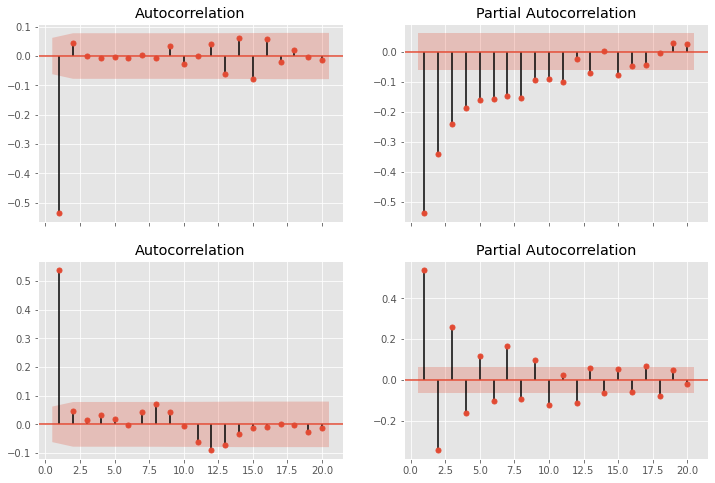

In [ ]:
fig, ax = plt.subplots(2,2,sharex=True)
plot_acf(simulated_data_MA1, zero=False, alpha=0.05, lags=20,ax=ax[0,0])
plot_pacf(simulated_data_MA1, zero=False,  alpha=0.05, lags=20,ax=ax[0,1])
plot_acf(simulated_data_MA2,zero=False, alpha=0.05, lags=20,ax=ax[1,0])
plot_pacf(simulated_data_MA2, zero=False, alpha=0.05, lags=20,ax=ax[1,1])
plt.show()

Un ejercicio similar al que hicimos en el caso de los modelos $AR$ permite concluir lo siguiente: Si los datos satisfacen
- la función de autocorrelación se desvanece después de un retraso $k$,
- la función de autocorrelación parcial va disminuyendo paso a paso,

podemos simular nuestros datos usando un modelo $MA(k)$. Al igual que en el caso de modelos $AR$ podemos hacer pronósticos una vez ajustamos nuestros datos a un modelo $MA$.

In [ ]:
modelo = ARMA(simulated_data_MA1, order=(0,1))
result = modelo.fit()

# Print out summary information on the fit
print(result.summary())

# Print out the estimate for the constant and for theta
print("Cuando theta=-0.9, el estimado de theta es:")
print(result.params[1])

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1444.240
Method:                       css-mle   S.D. of innovations              1.025
Date:                Sat, 29 May 2021   AIC                           2894.480
Time:                        00:56:17   BIC                           2909.203
Sample:                             0   HQIC                          2900.076
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.003      0.041      0.967      -0.006       0.006
ma.L1.y       -0.9083      0.012    -78.381      0.000      -0.931      -0.886
                                    Roots           

Ahora hacemos pronósticos 

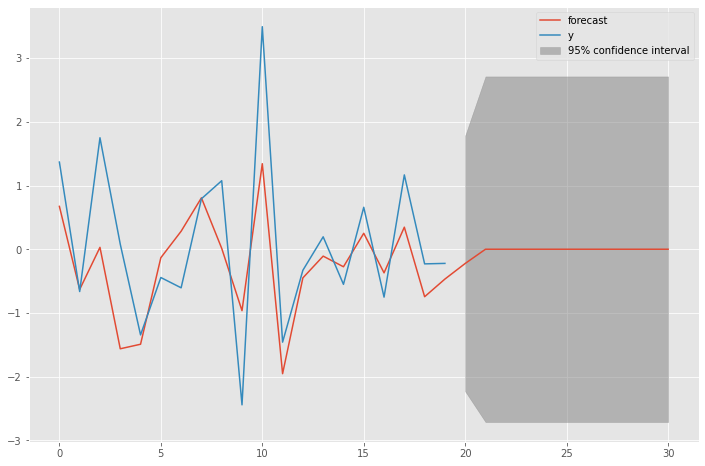

In [ ]:
result.plot_predict(start=980, end=1010)
plt.show()

### Modelos ARMA

Estos modelos son  modelos autoregresivos de media móvil. Es un modelo que combina las componentes del modelo $AR$ y del $MA$. Un modelos $ARMA(1,1)$ tiene la forma 

$$ x_t = \mu + \alpha x_{t-1} + \epsilon_t + \theta \epsilon_{t-1}. $$

La idea se generaliza para modelos $ARMA(m,n)$
$$x_t = \mu + \alpha_1 x_{t-1}+\cdots+ \alpha_m x_{t-m}+ \epsilon_t +\theta_1\epsilon_{t-1}+\cdots+\theta_n\epsilon_{t-n}$$

In [ ]:
## Ajustamos un modelo ARMA(1,1) a la temperatura
mode = ARMA(clima_sem,order=(1,1))
#entrenamos el modelo
res = mode.fit()
##Vemos los parámetros del model
print(res.params)

const                21.111076
ar.L1.Temperatura     0.709198
ma.L1.Temperatura    -0.306694
dtype: float64


In [ ]:
res.bic

288.44610697949

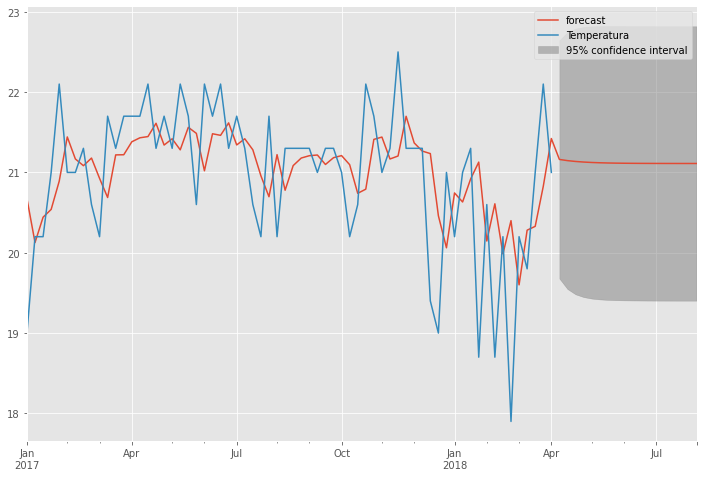

In [ ]:
res.plot_predict(start='2017',end='2018-08')
plt.show()

Como hicimos anteriormente con los modelos $AR$ y $MA$ podemos simular algunos procesos y ver el comportamiento de sus funciones de autocorrelación y autocorrelación parcial. Si nuestros datos satisfacen:
- la función de autocorrelación va disminuyendo en cada retraso, 
- la función de autocorrelación parcial va disminuyendo en cada retaso,

entonces podemos usar un modelo $ARMA(p,q)$ para simular los datos, aunque en este caso no es claro cómo escoger los números $p$ y $q$. En un escenario como este podemos consideras los índices BIC y AIC.


Podemos hacer una busqueda "a fuerza bruta" del modelo que mejor se ajusta a nuestros datos. Hagamos este ejercicio de nuevo con los datos del DataFrame `clima_sem`.

In [ ]:
orden_aic_bic=[]

# Iteramos sobre el coeficiente AR entre  0-2
for p in range(3):
  # Iteramos sobre el coeficioente MA entre 0-2
    for q in range(3):
      	# creamos y entrenamos el modelo ARMA(p,q) 
        model = ARMA(clima_sem.dropna(), order=(p,q))
        results = model.fit()
        
        # Adjuntamos a la lista los IC
        orden_aic_bic.append((p,q,results.aic, results.bic))

In [ ]:
# Construimos un Dataframe de orden_aic_bic
orden_df = pd.DataFrame(orden_aic_bic, 
                        columns=['p','q','AIC','BIC'])

# Lo imprimimos ordenando por AICC
print(orden_df.sort_values('AIC'))

# Ordenamos por BIC
print(orden_df.sort_values('BIC'))

   p  q         AIC         BIC
6  2  0  275.266826  286.349564
5  1  2  275.782932  289.636355
7  2  1  276.919957  290.773380
8  2  2  277.059110  293.683218
4  1  1  277.363368  288.446107
2  0  2  279.575853  290.658591
3  1  0  279.658953  287.971007
1  0  1  291.012804  299.324857
0  0  0  307.324729  312.866098
   p  q         AIC         BIC
6  2  0  275.266826  286.349564
3  1  0  279.658953  287.971007
4  1  1  277.363368  288.446107
5  1  2  275.782932  289.636355
2  0  2  279.575853  290.658591
7  2  1  276.919957  290.773380
8  2  2  277.059110  293.683218
1  0  1  291.012804  299.324857
0  0  0  307.324729  312.866098


Note que el modelo sugerido (por ambos criterios) para los datos en un $ARMA(2,0)$.

<font color='blue'>  
**Ejercicio:** Usando una busqueda como en la celda anterior determine cuál es el mejor modelos $ARMA$ para ajustar a la temperatura promedio diaria entre los meses de abril y julio del año 2017. El DataFrame `tempe` dado en la siguiente celda de código tiene los datos requeridos. </font>

In [ ]:
tempe = clima['2017-4':'2017-7']['Temperatura'].resample('D').mean()
#test = adfuller(tempe)
#test[1]
tempe.plot()
plt.show()

Ajustemos ahora un modelo $ARMA$ para los precios mensuales del café.

In [ ]:
cafe_m.head()

,Último,Retornos
Fecha,,
2010-01-31,131.95,NaN
2010-02-28,129.05,-2.90
2010-03-31,136.15,7.10
2010-04-30,135.20,-0.95
2010-05-31,134.30,-0.90


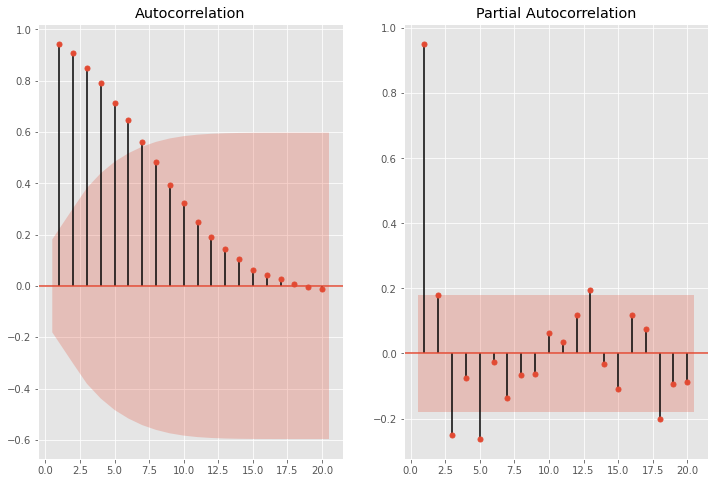

In [ ]:
fig, ax = plt.subplots(1,2)
plot_acf(cafe_m['Último'].dropna(),lags=20,zero=False,ax=ax[0])
plot_pacf(cafe_m['Último'].dropna(),lags=20,zero=False,ax=ax[1])
plt.show()

Vamos ahora a ajustar un modelo $ARMA(2,1)$ al precio mensual del café.

In [ ]:
modelo = ARMA(cafe_m['Último'].dropna(),order=(2,1))
resul = modelo.fit()
resul.params


const           141.755563
ar.L1.Último      0.088956
ar.L2.Último      0.834352
ma.L1.Último      0.721828
dtype: float64

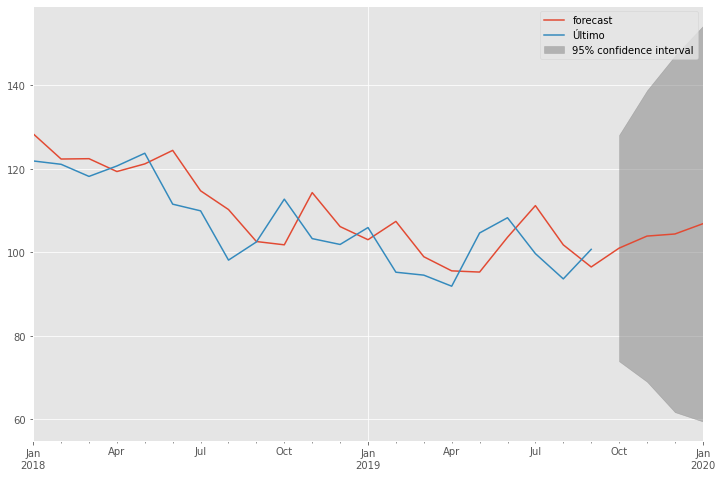

In [ ]:
resul.plot_predict(start='2018',end='2020')
plt.show()

**Nota: el pronóstico anterior sugiere un aumento modesto en el precio del café, pero ojo, la serie de precios del café no es estacionaria**

Una posible (entre muchas) extensión de los modelos ARMA son los modelos ARMAX donde se considera una variable externa (exógena) a la serie. Se puede pensar como una combinación de un modelo ARMA y una regresión linel. Un modelo ARMAX(1,1) sería 
$$ x_{t} =\mu + \alpha x_{t-1} + \theta \epsilon_{t-1} + \epsilon_t + a_1 y_t $$

Donde $y_t$ es la variable exógena. En este caso, para incluir la variable exógena se usa la siguiente instrucción 



```
 modelo = ARMA(data,order=(p,q),exog=variable_exogena)
 resultado = modelo.fit()
```
Veamos ahora una implementación de éste tipo. Estudiaremos de nuevo los precios del café con una variable exógena que es el precio del dólar en Colombia. Antes de hacer esta implementación haremos una "busqueda de malla" (search grid) para buscar el mejor modelo para la serie de retornos del precio del café.


In [ ]:
orden_aic_bic=[]

# Iteramos sobre el coeficiente AR entre  0-3
for p in range(4):
  # Iteramos sobre el coeficioente MA entre 0-3
    for q in range(4):
      	# creamos y entrenamos el modelo ARMA(p,q) cuando sea posible 
        try:
          model = ARMA(cafe_m['Retornos'].dropna(), order=(p,q))
          results = model.fit()
        
           # Adjuntamos a la lista los IC
          orden_aic_bic.append((p,q,results.aic, results.bic))
        except:
          ## Sino es posible, retornamos un NAN
          orden_aic_bic.append((p,q,None,None))
# DataFrame de orden_aic_bic
orden_df = pd.DataFrame(orden_aic_bic, 
                        columns=['p','q','AIC','BIC'])

# Ordenamos por AIC
print(orden_df.sort_values('AIC'))

# Ordenamos por BIC
#print(orden_df.sort_values('BIC'))

    p  q         AIC         BIC
9   2  1  949.122789  962.890740
8   2  0  949.229711  960.244072
2   0  2  949.906865  960.921225
6   1  2  950.162986  963.930937
12  3  0  950.757946  964.525897
10  2  2  950.915241  967.436782
13  3  1  951.114599  967.636141
14  3  2  951.176739  970.451870
3   0  3  951.567331  965.335282
4   1  0  952.989387  961.250158
1   0  1  954.770046  963.030816
0   0  0  956.397349  961.904529
5   1  1         NaN         NaN
7   1  3         NaN         NaN
11  2  3         NaN         NaN
15  3  3         NaN         NaN


**Tendremos en cuenta el AIC para ajustar nuestro modelo, es decir, un modelo $ARMA(2,1)$.

In [ ]:
dol = 'https://raw.githubusercontent.com/wincy-guerra/Times-Series-Data/main/1.1.1.TCM_Serie%20hist%C3%B3rica%20IQY_1.csv'
dolar = pd.read_csv(dol,sep=';')
dolar['Fecha'] = pd.to_datetime(dolar.Fecha,format= '%d/%m/%Y')
dolar.set_index('Fecha',inplace=True)
dolar['TRM'] = dolar['TRM'].apply(lambda x: x.replace('$',''))
dolar['TRM'] = dolar['TRM'].apply(lambda x: x.replace('.',''))
dolar['TRM'] = dolar['TRM'].apply(lambda x: x.replace(',','.'))
dolar['TRM'] = pd.to_numeric(dolar.TRM)
dolar.tail()

,TRM
Fecha,
2021-04-05,3678.62
2021-04-06,3645.79
2021-04-07,3645.14
2021-04-08,3639.62
2021-04-09,3634.07


Ahora juntaremos los datos en un solo DataFrame para ajustar el modelo.

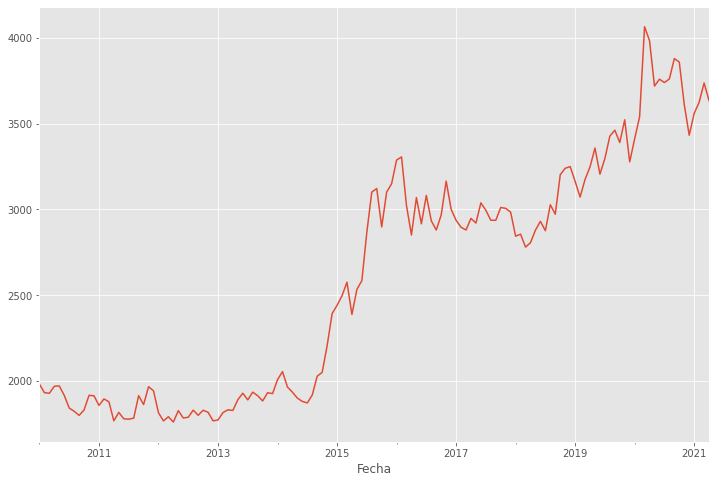

In [ ]:
dolar_m = dolar['TRM'].resample('M').last()
dolar_m['2010':].plot()
plt.show()

Para consultar detalles sobre las diferentes formas que existen en `Pandas` para juntar DataFrames puede consultad la [documentación aquí.](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html)

In [ ]:
cafe_dolar = pd.concat([cafe_m,dolar_m],axis=1,join='inner')
cafe_dolar.tail()

,Último,Retornos,TRM
Fecha,,,
2019-05-31,104.60,12.75,3357.82
2019-06-30,108.25,3.65,3205.67
2019-07-31,99.65,-8.60,3296.85
2019-08-31,93.60,-6.05,3427.29
2019-09-30,100.68,7.08,3462.01


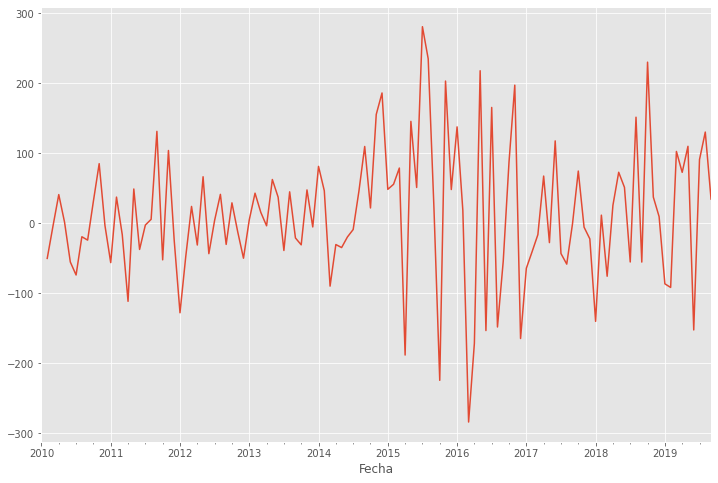

In [ ]:
cafe_dolar['dolar_ret'] = cafe_dolar['TRM'].diff()
cafe_dolar['dolar_ret'].plot()
plt.show()

In [ ]:
cafe_dolar.corr()

,Último,Retornos,TRM,dolar_ret
Último,1.000000,0.172446,-0.638953,-0.102567
Retornos,0.172446,1.000000,-0.042267,-0.194839
TRM,-0.638953,-0.042267,1.000000,0.152034
dolar_ret,-0.102567,-0.194839,0.152034,1.000000


Note que existe una correlación negativa entre el precio del dolar en Colombia y la cotización de la libra de café en Nueva York.

In [ ]:
modelo = ARMA(cafe_dolar['Retornos'].dropna(),order=(2,1),exog=cafe_dolar['dolar_ret'].dropna())
#entrenamos el modelo
resultado = modelo.fit()
print(resultado.params)

const             0.030902
dolar_ret        -0.020011
ar.L1.Retornos    0.334930
ar.L2.Retornos    0.304558
ma.L1.Retornos   -0.527626
dtype: float64


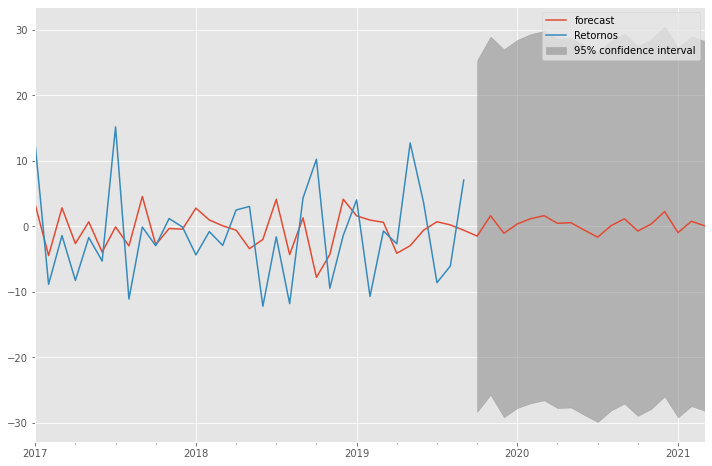

In [ ]:
resultado.plot_predict(start='2017',end='2021-03',exog=cafe_dolar['dolar_ret'].dropna())
plt.show()

## Modelos $ARIMA$ y $SARIMAX$.

Recuerde la serie de precios del café. Esta serie inicialmente no era estacionaria pero hicimos una transformación en los datos usando el método `.diff()` y obtuvimos una serie estacionaria. En teoría, podríamos ajustar un modelo $ARMA$ a la serie estacionaria, hacer pronósticos sobre esta serie de diferencias y luego, después de algunas operaciones matemáticas, obtener un pronóstico para la serie de precios del café (no para la serie de diferencias). 

Esto se puede hacer directamente implementado un modelo $ARIMA$, *Autoregressive Integrated Moving Average Model*, que es en esencia una generalización de los modelos $ARMA$.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Implementemos un modelo $ARIMA$ para los precios del café. En este caso usamos
- `SARIMAX(data,order=(p,d,q),exog=datos_exogenos)`

En este caso el argumento `order=(p,d,q)` el número p se refiere al grado de la parte  $AR$, q al grado de la parte $MA$ y $d$ es la cantidad de diferencias que tomamos hasta hacer a los datos estacionarios. Detalles y ejemplos sobre la clase `SARIMAX` pueden ser consultados [acá](https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_stata.html).

In [ ]:
modelo = SARIMAX(cafe_m['2014':]['Último'],order=(2,1,1))
#entrenamos el modelo
resultado = modelo.fit()
print(resultado.params)

ar.L1       0.419515
ar.L2       0.190651
ma.L1      -0.600819
sigma2    133.991622
dtype: float64


In [ ]:
pred_unpaso = resultado.get_prediction(start=-12,end='2020-2')
media_pred = pred_unpaso.predicted_mean
## Devuelve un DataFrame con los extremos del intervalo de confianza
int_conf = pred_unpaso.conf_int()
int_conf.head()

,lower Último,upper Último
2018-10-31,77.618396,122.993424
2018-11-30,87.695235,133.070263
2018-12-31,82.837730,128.212758
2019-01-31,78.981676,124.356704
2019-02-28,82.102658,127.477686


In [ ]:
# seleccionamos límites de confianza inferior y superior 
lower_limits = int_conf.loc[:,'lower Último']
upper_limits = int_conf.loc[:,'upper Último']

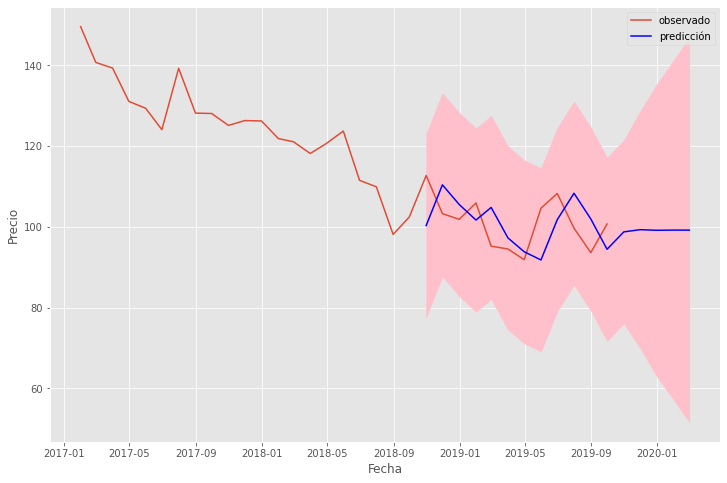

In [ ]:
plt.plot(cafe_m['2017':]['Último'].index,cafe_m['2017':]['Último'], label='observado')
plt.plot(media_pred.index,media_pred,color='b',label='predicción')
plt.fill_between(lower_limits.index,lower_limits,upper_limits,color='pink')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()

El pronóstico hecho anteriormente se conoce como pronóstico a un paso, es decir, el precio de mañana lo pronostico usando el precio de hoy. Para calcular el precio de pasado mañana uso el precio de mañana (no mi pronóstico anterior) y así sucesivamente. También podemos hacer las predicciones solo basados en nuestros pronósticos, que es como se haría para pronosticar precios futuros (out-sample). Este tipo de predicción de conoce como dinámica.

In [ ]:
pred_din = resultado.get_prediction(start=-8,dynamic=True)
media_pred = pred_din.predicted_mean
## Devuelve un DataFrame con los extremos del intervalo de confianza
int_conf = pred_din.conf_int()

In [ ]:
# Select lower and upper confidence limits
lower_limits = int_conf.loc[:,'lower Último']
upper_limits = int_conf.loc[:,'upper Último']
## Graficamos la predicción dinámica 
plt.plot(cafe_m['2017':]['Último'].index,cafe_m['2017':]['Último'], label='observado')
plt.plot(media_pred.index,media_pred,color='b',label='predicción')
plt.fill_between(lower_limits.index,lower_limits,upper_limits,color='pink')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()

Ahora trataremos de implementar un modelo $SARIMA$. En este caso la S se refiere a *seasonal*, es decir un *seasonal ARIMA model*. Una serie de tiempo se puede descomponer en tres partes fundamentales:
- una tendencia, 
- Una componente estacional,
- Una componente puramente aleatoria (ruido).



In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
##Hallamos la descomposición de los datos en la serie
decompo = seasonal_decompose(cafe_m['Retornos'].dropna())

**Nota:** Si su DataFrame no tiene una frecuencia, es posible que en la función `seasonal_decompose()` deba usar el argumento `freq='número'`.

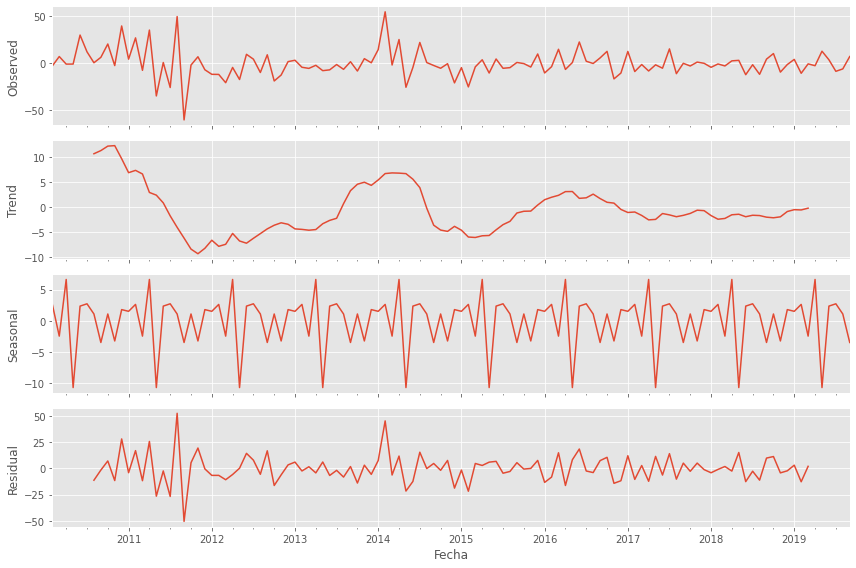

In [ ]:
decompo.plot()
plt.show()

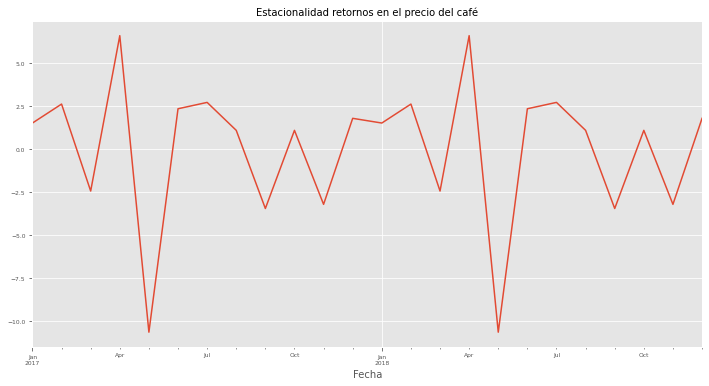

In [ ]:
seasonal = decompo.seasonal
# Plot the values of the trend
ax = seasonal['2017':'2018'].plot(figsize=(12, 6), fontsize=6)

# Specify axis labels
ax.set_xlabel('Fecha', fontsize=10)
ax.set_title('Estacionalidad retornos en el precio del café', fontsize=10)
plt.show()

Las componentes estacionales en una serie de tiempo hacen que la serie no sea estacionaria. Algunas veces estas componentes de estacionalidad no son captadas por el test de Dickey-Fuller. Una forma de ver los patrones en el comportamiento de una serie de tiempo es graficar las funciones de autocorrelación y autocorrelación parcial. Un pico sobresaliente después de los primeros retrasos indican una componente de estacionalidad.  Grafiquemos de nuevo la función de autocorrelación parcial para los retornos en el  precio mensual del café.

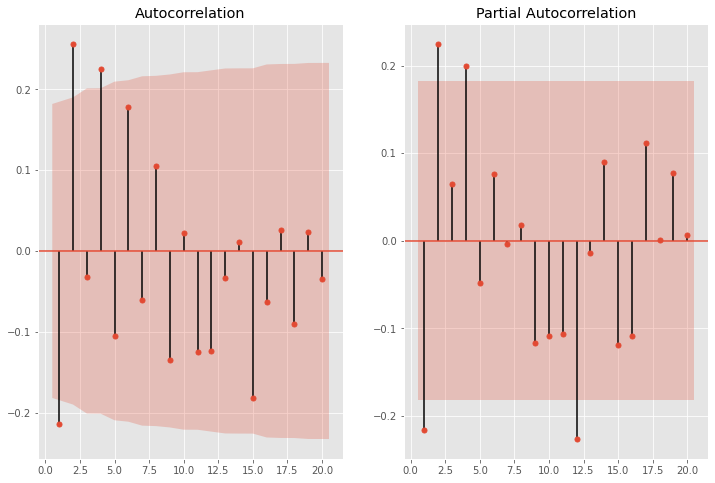

In [ ]:
fig, ax = plt.subplots(1,2)
plot_acf(cafe_m['Retornos'].dropna(),lags=20,zero=False,ax=ax[0])
plot_pacf(cafe_m['Retornos'].dropna(),lags=20,zero=False,ax=ax[1])
plt.show()

Al igual que en los casos de los modelos $ARMA$, los picos en los  retrasos de las funciones pueden sugerir las componentes del modelo autoregresivo y de media móvil para la componente estacional. Por ejemplo, la función de autocorrelación parcial sugiere una componente autoregresiva cada 12 meses. Detalles sobre como detectar componentes de estacionalidad usando las funciones de autocorrelación y autocorrelación parcial puede ser consultados [acá](https://online.stat.psu.edu/stat510/lesson/4/4.1).

In [ ]:
cafe_m.shape

Un modelo $SARIMA$ contiene 7 parámetros y se denota $SARIMA(p,d,q)(P,D,Q)_S$. En este caso los parámetros $p,d,q$ son los mismos del modelo $ARIMA$. Los parámetros $P,D,Q$ tienen la misma interpretación en el caso de la componente estacional. Supongamos que identificamos estacionalidad en los datos cada 12 meses, un modelo $SARIMA(0,0,0)(1,0,1)_{12}$ tendría la forma

$$ X_t = \alpha X_{t-12} + \theta\epsilon_{t-12} +\epsilon_t. $$


La misma guía que dedujimos antes, para escoger modelos autoregresivos o de media móvil teniendo en cuenta los funciones de autocorrelación y de autocorrelación parcial, las podemos aplicar para escoger el orden de la componente estacional en el modelo $SARIMA$. En este enlace pueden ver un ejemplo detallado del modelo $SARIMA$ en Python: [acá](https://towardsdatascience.com/time-series-forecasting-with-sarima-in-python-cda5b793977b)

De esta forma la función de autocorrelación parcial para el precio mensual del café sugiere una componete autoregresiva estacional cada 12 meses.

In [ ]:
cafe_m.head()

En la celda siguiente implementaremos un modelo $SARIMA(2,1,0)(1,0,0)_{12}$ para el precio mensual del café.

In [ ]:
modelo = SARIMAX(cafe_m['Último'].dropna(),order=(2,1,1),seasonal_order=(1,0,0,12))
resultados = modelo.fit()

In [ ]:
resultados.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             Último   No. Observations:                  117
Model:             SARIMAX(2, 1, 1)x(1, 0, 0, 12)   Log Likelihood                -467.993
Date:                            Sat, 29 May 2021   AIC                            945.987
Time:                                    01:50:32   BIC                            959.755
Sample:                                01-31-2010   HQIC                           951.576
                                     - 09-30-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3242      0.191      1.696      0.090      -0.051       0.699
ar.L2          0.3377      0.068      4.983      0.000       0.205       0.470
ma.L1         -0.5565      0.202     -2.760      0.006      -0.952      -0.161
ar.S.L12      -0.1706      0.134     -1.275      0.202      -0.433       0.092
sigma2       186.0813     16.062     11.585      0.000     154.601     217.562
===================================================================================
Ljung-Box (Q):                       35.55   Jarque-Bera (JB):                60.75
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                             0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
pred_din_s = resultados.get_prediction(start=-8,end='2019-12')
media_pred_s = pred_din_s.predicted_mean
## Devuelve un DataFrame con los extremos del intervalo de confianza
int_conf = pred_din_s.conf_int()

In [ ]:
int_conf.head()

,lower Último,upper Último
2019-02-28,77.610859,131.083225
2019-03-31,71.652612,125.124979
2019-04-30,65.454994,118.927360
2019-05-31,63.659200,117.131566
2019-06-30,75.591623,129.063989


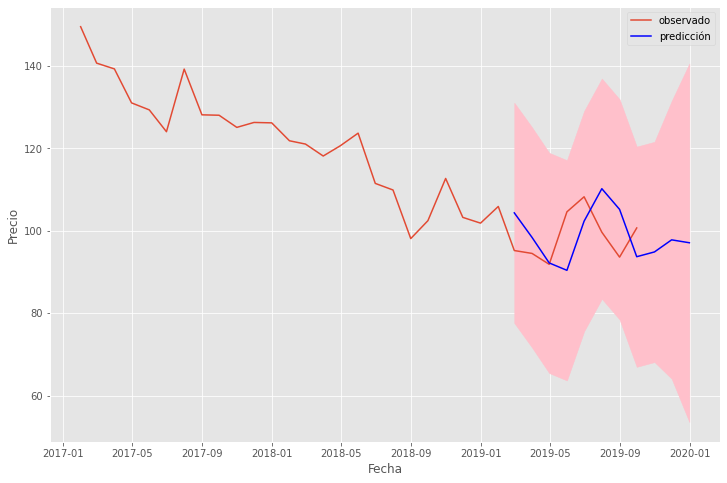

In [ ]:
lower_limits = int_conf.loc[:,'lower Último']
upper_limits = int_conf.loc[:,'upper Último']
## Graficamos la predicción dinámica 
plt.plot(cafe_m['2017':]['Último'].index,cafe_m['2017':]['Último'], label='observado')
plt.plot(media_pred_s.index,media_pred_s,color='b',label='predicción')
plt.fill_between(lower_limits.index,lower_limits,upper_limits,color='pink')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()

## Diagnóstico para modelos $SARIMA$.

Los métodos estándar para evaluar el ajuste de un modelo $SARIMAX$ están basados en análisis sobre los residuos: la diferencia entre los valores reales y los pronosticados.



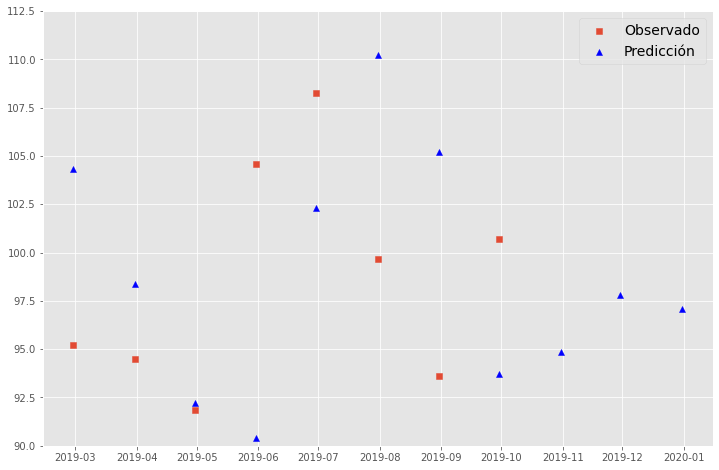

In [ ]:
plt.scatter(cafe_m.loc['2019-02':].index,cafe_m.loc['2019-02':]['Último'],marker='s',label='Observado')
plt.scatter(media_pred_s.index,media_pred_s,color='b',marker='^',label='Predicción')
#plt.plot(['2019-06','2019-06'],[103.86,108.25])
#plt.plot(['2019-06','2019-07'],[100,105])
plt.ylim([90, 112.5])
plt.legend(fontsize=14)
plt.show()

Nosotros podemos acceder a los residuos usando el atributo `.resid` sobre el modelo ajustado. Recordemos el modelo $SARIMA$ que ajustamos anteriormente para el precio mensual del café.

In [ ]:
modelo = SARIMAX(cafe_m['Último'].dropna(),order=(2,1,1),seasonal_order=(1,0,0,12),trend='c')
resultados = modelo.fit()

In [ ]:
print(resultados.aic,resultados.bic)

Accedamos a los residuos del año 2014.

In [ ]:
residuos = resultados.resid
print(residuos['2014'])

Para conocer, en promedio, qué tal alejados están nuestros pronósticos de los valores reales, podemos calcular el **error absoluto medio (Mean absolute error)** usando la fórmula `eam = np.mean(np.abs(residuos))`.

In [ ]:
np.mean(np.abs(residuos))

Teniendo en cuenta que la media del precio del café en nuestros datos es 152 centavos de dólar (¿cómo sabemos esto?) el dato anterior nos dice que el error medio es de 10.8 centavos (al rededor del 7%).

En un modelo que se ajuste bien a los datos se espera que los residuos se comporten como un ruido blanco gaussiano. El método `.plot_diagnostics()` nos permite visualizar 4 de los métodos más usados para evaluar nuestro modelo. Los gráficos que veremos se refieren al análisis de los residuos.


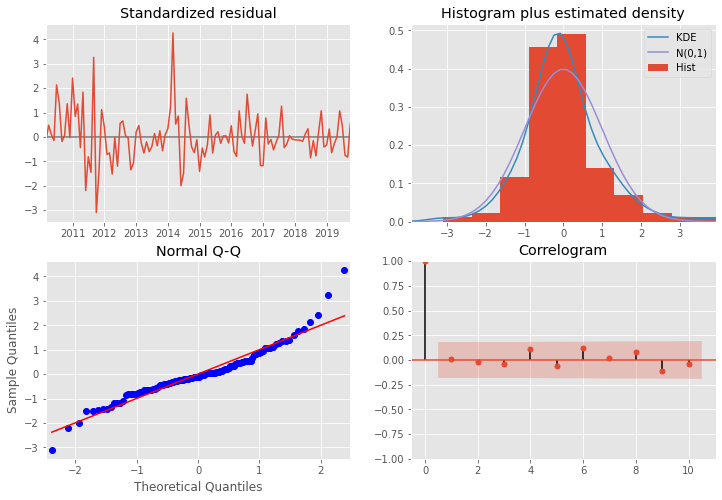

In [ ]:
resultados.plot_diagnostics()
plt.show()

- El gráfico superior izquierdo muestra las trayectorias de los residuos estandarizados; estas trayectorias no deben mostras ninguna estructura claramente definida. 

- La gráfica superior derecha muestra la distribución de nuestros residuos, la cuál debe ser similar a la distribución normal, es decir, las dos curvas que vemos deben ser muy parecidas.

- El test normal Q-Q es otra forma de comparar los residuos con la distribución normal. Si los residuos están distribuidos de forma normal, los puntos deberían estar distribuidos a lo largo de la línea, excepto quizás en los extremos de la recta.

- En último gráfico es un correlograma: la función de autocorrelación de los residuos. Los valores de esta función deben ser iguales a cero (vivir en la franja sombreada). Si existe algún valor significativamente distinto de cero en el correlograma se asume que los datos tienen información que nuestro modelo aún no está usando.

El método `.summary()` incluye p valores para algunas pruebas de hipótesis que evaluan la distribución de los residuos.


In [ ]:
print(resultados.summary())

- Prob(Q) es el p valor asociado a la hipótesis nula: *los residuos no están correlacionados*.
- Prob(JB) es el p valor asociado a la hipótesis nula:  *los residuos están distribuidos de forma normal (gaussiana)*. 

Si los valores son menores a 0.05 rechazamos esas hipótesis.

## Ejercicios

Considere los siguientes datos sobre temperatura media diaria.

In [ ]:
tempe = clima['2017-4':'2017-7']['Temperatura'].resample('D').mean()
#test = adfuller(tempe)
#test[1]
tempe.plot()
plt.show()

1. Determinar si la serie es estacionaria.
2. Grafique las funciones de autocorrelación y autocorrelación parcial para los datos.
3. Haga una busqueda de malla para determinar el mejor modelo $ARMA$ que se ajuste al modelo. Ajuste un modelo $ARMA$ según esta busqueda.
4. ¿Se pueden considerar, segun lo visto en clase, componentes estacionales? Si es así, ajuste un modelo $SARIMA$ a los datos.
5. Haga dignósticos para los modelos implementados.


In [ ]:
plot_pacf((clima_sem['Temperatura'] - clima_sem['Temperatura'].rolling(12).mean()).dropna(),lags=60)
plt.show()